# Feature Engineering Code-along

In this notebook, we use the following feature engineering strategies:
1. scaling
2. binning
3. log transformation
4. PCA

The data regards students, features about them, and their scores on an exam.  The orginal data can be found [here on Kaggle](https://www.kaggle.com/datasets/uciml/student-alcohol-consumption)

We will use some feature engineering on our data and then try to predict whether students will pass the exam.

The minimum passing score is 12

# Data Dictionary

1. school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)
2. sex - student's sex (binary: 'F' - female or 'M' - male)
3. age - student's age (numeric: from 15 to 22)
4. address - student's home address type (binary: 'U' - urban or 'R' - rural)
5. famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)
6. Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart)
7. Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
8. Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
9. Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
10. Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
11. reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
12. guardian - student's guardian (nominal: 'mother', 'father' or 'other')
13. traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
14. studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
15. failures - number of past class failures (numeric: n if 1<=n<3, else 4)
16. schoolsup - extra educational support (binary: yes or no)
17. famsup - family educational support (binary: yes or no)
18. paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
19. activities - extra-curricular activities (binary: yes or no)
20. nursery - attended nursery school (binary: yes or no)
21. higher - wants to take higher education (binary: yes or no)
22. internet - Internet access at home (binary: yes or no)
23. romantic - with a romantic relationship (binary: yes or no)
24. famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
25. freetime - free time after school (numeric: from 1 - very low to 5 - very high)
26. goout - going out with friends (numeric: from 1 - very low to 5 - very high)
27. Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
28. Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
29. health - current health status (numeric: from 1 - very bad to 5 - very good)
30. absences - number of school absences (numeric: from 0 to 93)


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay, \
classification_report

from sklearn import set_config
set_config(transform_output='pandas')

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

# Useful Functions

In [3]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
    
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict



# Load Data


In [4]:
# load data
import glob
math_files = sorted(glob.glob('Data/Students/*.csv'))
math_files

['Data/Students\\Student_Performance-mat_age-15.csv',
 'Data/Students\\Student_Performance-mat_age-16.csv',
 'Data/Students\\Student_Performance-mat_age-17.csv',
 'Data/Students\\Student_Performance-mat_age-18.csv',
 'Data/Students\\Student_Performance-mat_age-19.csv',
 'Data/Students\\Student_Performance-mat_age-20.csv',
 'Data/Students\\Student_Performance-mat_age-21.csv',
 'Data/Students\\Student_Performance-mat_age-22.csv']

In [5]:
port_files = sorted(glob.glob('Data/Students/Portugese/*.csv'))
port_files

['Data/Students/Portugese\\Student_Performance-por_age-15.csv',
 'Data/Students/Portugese\\Student_Performance-por_age-16.csv',
 'Data/Students/Portugese\\Student_Performance-por_age-17.csv',
 'Data/Students/Portugese\\Student_Performance-por_age-18.csv',
 'Data/Students/Portugese\\Student_Performance-por_age-19.csv',
 'Data/Students/Portugese\\Student_Performance-por_age-20.csv',
 'Data/Students/Portugese\\Student_Performance-por_age-21.csv',
 'Data/Students/Portugese\\Student_Performance-por_age-22.csv']

In [6]:
math = pd.concat([pd.read_csv(file) for file in math_files])
port = pd.concat([pd.read_csv(file) for file in port_files])

df = pd.concat([math, port])

df_backup = df.copy()

df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,subject,Semester,Grade
0,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,mat,G1,7
1,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,mat,G1,15
2,GP,M,15,U,LE3,A,3,2,services,other,home,mother,1,2,0,no,yes,yes,no,yes,yes,yes,no,4,2,2,1,1,1,0,mat,G1,16
3,GP,M,15,U,GT3,T,3,4,other,other,home,mother,1,2,0,no,yes,yes,yes,yes,yes,yes,no,5,5,1,1,1,5,0,mat,G1,14
4,GP,F,15,U,GT3,T,4,4,teacher,health,reputation,mother,1,2,0,no,yes,yes,no,yes,yes,yes,no,3,3,3,1,2,2,0,mat,G1,10


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3132 entries, 0 to 2
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      3132 non-null   object
 1   sex         3132 non-null   object
 2   age         3132 non-null   int64 
 3   address     3132 non-null   object
 4   famsize     3132 non-null   object
 5   Pstatus     3132 non-null   object
 6   Medu        3132 non-null   int64 
 7   Fedu        3132 non-null   int64 
 8   Mjob        3132 non-null   object
 9   Fjob        3132 non-null   object
 10  reason      3132 non-null   object
 11  guardian    3132 non-null   object
 12  traveltime  3132 non-null   int64 
 13  studytime   3132 non-null   int64 
 14  failures    3132 non-null   int64 
 15  schoolsup   3132 non-null   object
 16  famsup      3132 non-null   object
 17  paid        3132 non-null   object
 18  activities  3132 non-null   object
 19  nursery     3132 non-null   object
 20  higher     

## Explore and clean the data

In [8]:
# Check for duplicates

df.duplicated().sum()

0

In [9]:
# Check for missing values

df.isna().sum().sum()

0

In [10]:
# Check summary statistics

df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,Grade
count,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000
mean,16.726054,2.603448,2.387931,1.522989,1.970307,0.264368,3.935824,3.201149,3.156130,1.494253,2.284483,3.543103,4.434866,11.267241
std,1.239579,1.124547,1.099587,0.731494,0.834087,0.655932,0.933103,1.031177,1.152206,0.911423,1.284694,1.424248,6.208033,3.396850
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,9.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.250000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,20.000000


In [11]:
df.describe(exclude='number')

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,subject,Semester
count,3132,3132,3132,3132,3132,3132,3132,3132,3132,3132,3132,3132,3132,3132,3132,3132,3132,3132,3132
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2,2,3
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,no,yes,yes,yes,no,por,G1
freq,2316,1773,2277,2214,2769,1197,1752,1290,2184,2775,1920,2472,1584,2505,2865,2481,2019,1947,1044


# Converting Regression to Classification: Binning the Target

What our stakeholders really want to know is which students will pass and which students will fail the exam.  We also know that a passing score is 12 or higher.  Using this knowledge we can bin the target into passing and failing scores.

## Applying a function

In [12]:
## Define a function
def bin_target(x):
    if x >= 12:
        return 1
    else: 
        return 0

## Apply the Function
df['passed'] = df['Grade'].apply(lambda x: 1 if x >= 12 else 0)
## Check Value counts
df['passed']


0    0
1    1
2    1
3    1
4    0
    ..
4    1
5    0
0    0
1    0
2    0
Name: passed, Length: 3132, dtype: int64

In [13]:
df = df.drop('Grade', axis=1)
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,subject,Semester,passed
0,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,mat,G1,0
1,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,mat,G1,1
2,GP,M,15,U,LE3,A,3,2,services,other,home,mother,1,2,0,no,yes,yes,no,yes,yes,yes,no,4,2,2,1,1,1,0,mat,G1,1
3,GP,M,15,U,GT3,T,3,4,other,other,home,mother,1,2,0,no,yes,yes,yes,yes,yes,yes,no,5,5,1,1,1,5,0,mat,G1,1
4,GP,F,15,U,GT3,T,4,4,teacher,health,reputation,mother,1,2,0,no,yes,yes,no,yes,yes,yes,no,3,3,3,1,2,2,0,mat,G1,0


# Feature Engineering

## Combining Features

Walc is weekend alcohol consumption and Dalc is weekday alcohol consumption.  We can combine these into one column, overall alcohol consumption.

In [14]:
# Add together the different alcohol consumption columns
df['TotAlc'] = df['Walc'] + df['Dalc']
df.drop(columns=['Walc', 'Dalc'], inplace=True)
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,subject,Semester,passed,TotAlc
0,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,3,10,mat,G1,0,5
1,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,5,2,mat,G1,1,2
2,GP,M,15,U,LE3,A,3,2,services,other,home,mother,1,2,0,no,yes,yes,no,yes,yes,yes,no,4,2,2,1,0,mat,G1,1,2
3,GP,M,15,U,GT3,T,3,4,other,other,home,mother,1,2,0,no,yes,yes,yes,yes,yes,yes,no,5,5,1,5,0,mat,G1,1,2
4,GP,F,15,U,GT3,T,4,4,teacher,health,reputation,mother,1,2,0,no,yes,yes,no,yes,yes,yes,no,3,3,3,2,0,mat,G1,0,3



## Binary Encoding

In [15]:
## Replace 'yes' and 'no' with 1 and 0
# df = df.replace({'yes':1, 'no':0, 'F':0, 'M':1, 'GT3':1, 'LE3':0})
# df.describe()

,sex,age,famsize,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,passed,TotAlc
count,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000
mean,0.433908,16.726054,0.706897,2.603448,2.387931,1.522989,1.970307,0.264368,0.113985,0.613027,0.210728,0.494253,0.799808,0.914751,0.792146,0.355364,3.935824,3.201149,3.156130,3.543103,4.434866,0.467752,3.778736
std,0.495692,1.239579,0.455258,1.124547,1.099587,0.731494,0.834087,0.655932,0.317843,0.487135,0.407891,0.500047,0.400208,0.279297,0.405837,0.478700,0.933103,1.031177,1.152206,1.424248,6.208033,0.499039,1.987799
min,0.000000,15.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000
25%,0.000000,16.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,3.000000,0.000000,0.000000,2.000000
50%,0.000000,17.000000,1.000000,3.000000,2.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,3.000000,4.000000,2.000000,0.000000,3.000000
75%,1.000000,18.000000,1.000000,4.000000,3.000000,2.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,4.000000,4.000000,5.000000,6.000000,1.000000,5.000000
max,1.000000,22.000000,1.000000,4.000000,4.000000,4.000000,4.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,75.000000,1.000000,10.000000


## Combining Columns

In [16]:
## Combine the school and subject
df['school/subject'] = df['school'] + ' ' + df['subject']

## drop original columns
df = df.drop(columns=['school','subject'])
df.head()

,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,Semester,passed,TotAlc,school/subject
0,0,15,U,0,T,1,1,at_home,other,other,mother,1,2,3,1,0,1,0,1,1,1,0,4,3,2,3,10,G1,0,5,GP mat
1,0,15,U,1,T,4,2,health,services,home,mother,1,3,0,0,1,1,1,1,1,1,1,3,2,2,5,2,G1,1,2,GP mat
2,1,15,U,0,A,3,2,services,other,home,mother,1,2,0,0,1,1,0,1,1,1,0,4,2,2,1,0,G1,1,2,GP mat
3,1,15,U,1,T,3,4,other,other,home,mother,1,2,0,0,1,1,1,1,1,1,0,5,5,1,5,0,G1,1,2,GP mat
4,0,15,U,1,T,4,4,teacher,health,reputation,mother,1,2,0,0,1,1,0,1,1,1,0,3,3,3,2,0,G1,0,3,GP mat


## Reducing Outliers: Log transformation

<Axes: >

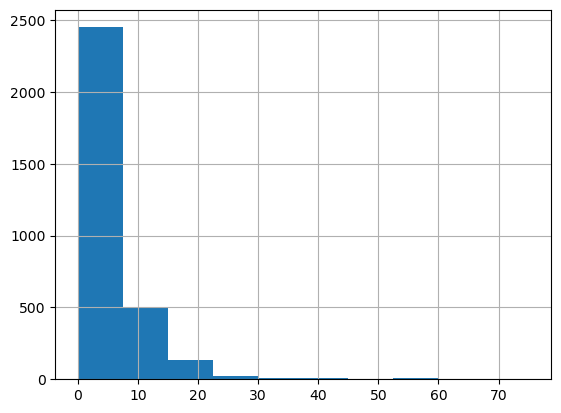

In [17]:
## Check distribution of absences
df['absences'].hist()

We could just drop the outliers, or we can do a log transform to squick them closer to the other values.  This makes the data more normal without losing any information.

We can't get the natural log of 0, so we will just add one to each value to make sure there are no 0s.

<Axes: >

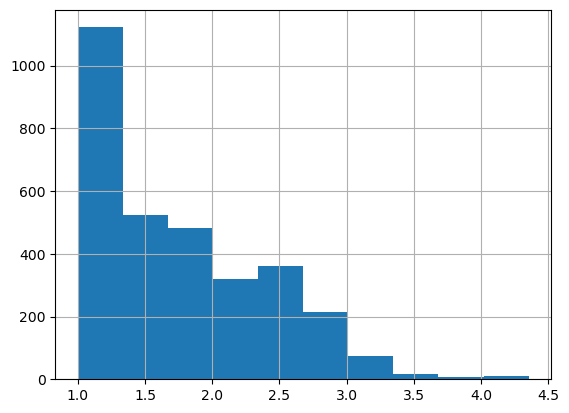

In [25]:
## Log Transform Absences
np.log(df['absences']+np.e).hist()


## PCA

PCA will cause data leakage if we apply it to all rows, since it needs to look at all rows to determine how to transform the data.

<font color='red'> We must do the PCA transformation AFTER the split </font>

In [26]:
## Split the data
X = df.drop('passed', axis=1)
y = df['passed'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.head()

,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,Semester,TotAlc,school/subject
15,1,17,U,1,T,3,3,other,other,reputation,father,1,2,0,0,0,0,1,0,1,1,0,4,3,4,4,4,G1,5,GP mat
48,1,19,U,1,T,2,1,other,other,reputation,mother,1,1,0,0,0,0,0,1,1,1,0,5,3,4,4,10,G2,5,GP por
259,1,18,U,0,T,1,1,other,services,home,father,2,1,0,0,0,0,0,0,1,1,1,3,3,2,3,2,G2,3,MS por
28,0,15,U,0,T,4,2,health,other,other,mother,1,2,0,0,1,0,0,1,1,1,0,4,3,3,5,0,G1,2,GP por
41,0,17,U,1,T,3,2,other,other,course,mother,1,2,0,0,0,0,1,0,1,1,0,5,3,4,3,2,G1,4,GP por


### Preprocessor

We will one-hot encode the data, scale it, and then PCA transform it.

In [27]:
## define transformers
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse_output=False)

## Select Columns

num_cols = X_train.select_dtypes(include='number').columns
cat_cols = X_train.select_dtypes(include='object').columns

## define tuples

num_tuple = ('Numeric', scaler, num_cols)
cat_tuple = ('Nominal', ohe, cat_cols)

#### preprocessing pipeline

In [31]:
from sklearn.decomposition import PCA

In [32]:
## Define the column transformer
col_trans = ColumnTransformer([num_tuple, cat_tuple], verbose_feature_names_out=False)

## Combine the column transformer with a PCA model to transform the data.
pca = PCA(n_components=.95)
preprocessor = make_pipeline(col_trans, pca)

## Transform the data

Let's compare the number of columns with and without PCA

In [30]:
col_trans.fit_transform(X_train).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2349 entries, 15 to 8
Data columns (total 48 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sex                    2349 non-null   float64
 1   age                    2349 non-null   float64
 2   famsize                2349 non-null   float64
 3   Medu                   2349 non-null   float64
 4   Fedu                   2349 non-null   float64
 5   traveltime             2349 non-null   float64
 6   studytime              2349 non-null   float64
 7   failures               2349 non-null   float64
 8   schoolsup              2349 non-null   float64
 9   famsup                 2349 non-null   float64
 10  paid                   2349 non-null   float64
 11  activities             2349 non-null   float64
 12  nursery                2349 non-null   float64
 13  higher                 2349 non-null   float64
 14  internet               2349 non-null   float64
 15  romant

In [35]:
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)
X_train_proc.shape

(2349, 30)

## Examine the explained variance of each principal component

Text(0, 0.5, 'Explained Variance')

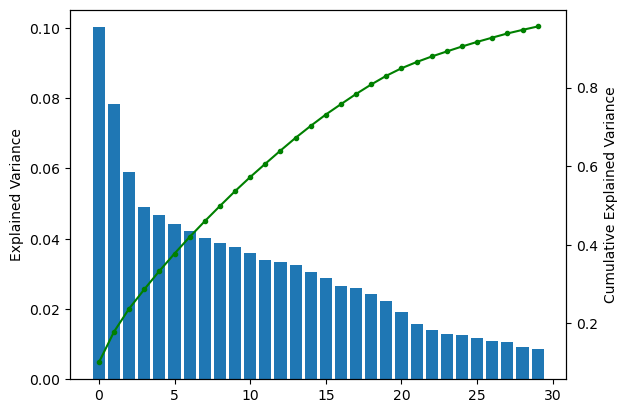

In [34]:
## Plot the explained variance ratio of the pca components
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
line1 = ax2.plot(range(pca.n_components_), pca.explained_variance_ratio_.cumsum(), c='g', 
                 marker='.', label='cumulative explained variance')
ax2.set_ylabel('Cumulative Explained Variance')
line2 = ax1.bar(range(pca.n_components_), pca.explained_variance_ratio_, label='explained variance')
ax1.set_ylabel('Explained Variance')


# Model the engineered data

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1255
           1       0.86      0.86      0.86      1094

    accuracy                           0.87      2349
   macro avg       0.87      0.87      0.87      2349
weighted avg       0.87      0.87      0.87      2349



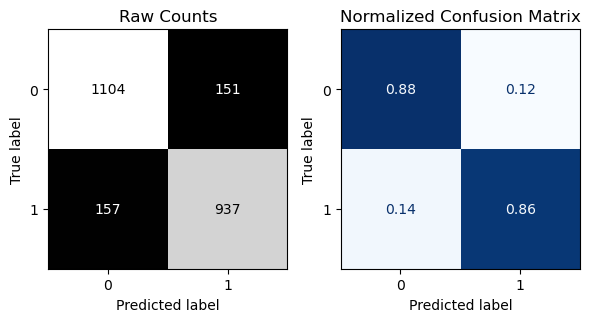


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.76      0.75       412
           1       0.73      0.70      0.71       371

    accuracy                           0.73       783
   macro avg       0.73      0.73      0.73       783
weighted avg       0.73      0.73      0.73       783



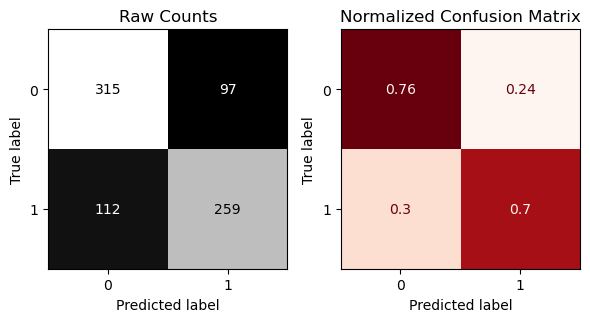

In [36]:
## Define the model
knn_eng = KNeighborsClassifier()

## Fit the model
knn_eng.fit(X_train_proc, y_train)

## Evaluate the model
evaluate_classification(knn_eng, X_train_proc, y_train, 
                 X_test_proc, y_test)